### Same Test and Train Data

Total iterations: 874
Total Original Model data: 2


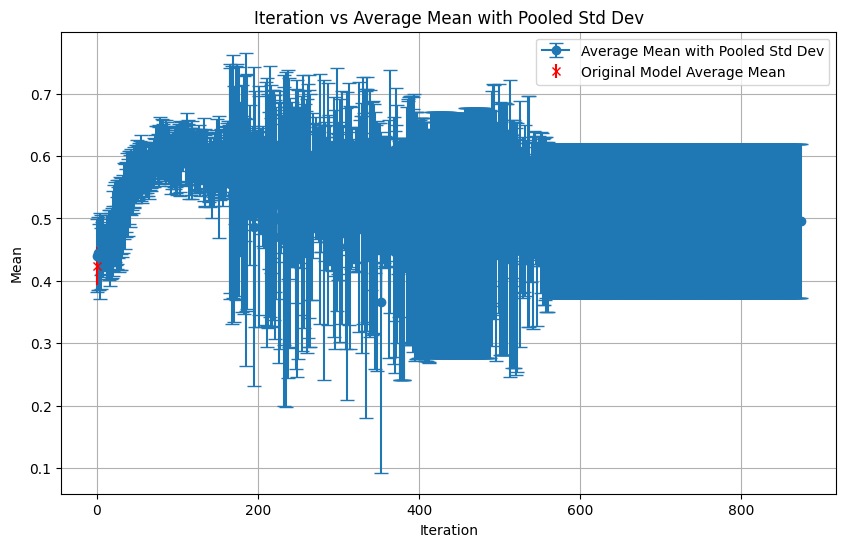

Total iterations: 874
Total Original Model data: 2


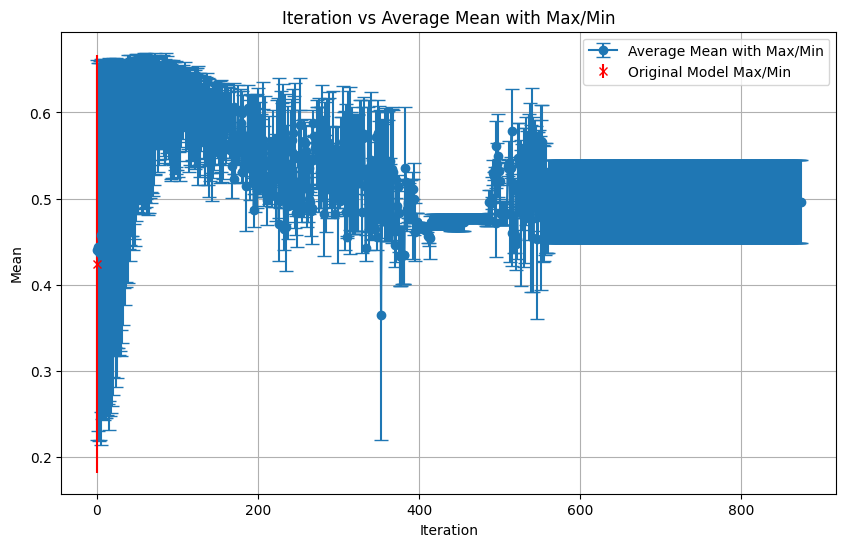

In [4]:
model_output_dir = '/work/b0990106x/trl/model_output/1018-2305'
log_path = f'{model_output_dir}/log_training.log'

import re
import matplotlib.pyplot as plt
import ast
import numpy as np

# Function to parse the log file for both EVAL and Original model metrics
def parse_log_file(log_path):
    eval_pattern = re.compile(
        r"EVAL: Cosine_Sim metrics Training Set for iteration (\d+): (.+)"
    )
    original_model_pattern = re.compile(
        r"Original model metrics on training set: (.+)"
    )
    
    data = {"EVAL": {}, "Original": []}

    # Read the log file line by line
    with open(log_path, 'r') as log_file:
        for line in log_file:
            eval_match = eval_pattern.search(line)
            original_match = original_model_pattern.search(line)

            # If it's an EVAL line
            if eval_match:
                iteration = int(eval_match.group(1)) + 1  # Adding 1 to iteration as requested
                metrics_list = eval_match.group(2).strip()

                # Convert the metrics_list string to a Python object (list of dicts)
                metrics_list = ast.literal_eval(metrics_list)

                # Store means and std_devs for this iteration
                means = []
                std_devs = []
                counts = []

                for metrics in metrics_list:
                    mean = metrics['metrics']['mean']
                    std_dev = metrics['metrics']['std_dev']
                    count = len(metrics['metrics']['rewards'])  # Number of rewards is the sample size

                    means.append(mean)
                    std_devs.append(std_dev)
                    counts.append(count)

                # Store mean, std_dev, and count for each iteration
                data["EVAL"][iteration] = {
                    "means": means,
                    "std_devs": std_devs,
                    "counts": counts
                }

            # If it's an Original Model Metrics line
            elif original_match:
                metrics_list = original_match.group(1).strip()

                # Convert the metrics_list string to a Python object (list of dicts)
                metrics_list = ast.literal_eval(metrics_list)

                for metrics in metrics_list:
                    mean = metrics['metrics']['mean']
                    std_dev = metrics['metrics']['std_dev']
                    data["Original"].append((mean, std_dev))

    return data

# Function to calculate the pooled standard deviation
def pooled_std_dev(std_devs, counts):
    # Pooled variance formula
    numerator = sum((counts[i] - 1) * (std_devs[i] ** 2) for i in range(len(std_devs)))
    denominator = sum(counts[i] - 1 for i in range(len(counts)))

    if denominator > 0:
        pooled_variance = numerator / denominator
        return np.sqrt(pooled_variance)
    else:
        return 0  # In case of single value or no variance

# Function to plot iteration vs the average mean and pooled std_dev
def plot_metrics(data):
    plt.figure(figsize=(10, 6))

    # Plot EVAL data (average across all idx)
    iterations = sorted(data["EVAL"].keys())
    avg_means = []
    pooled_std_devs = []
    
    print(f"Total iterations: {len(iterations)}")
    print(f"Total Original Model data: {len(data['Original'])}")

    for iteration in iterations:
        means = data["EVAL"][iteration]["means"]
        std_devs = data["EVAL"][iteration]["std_devs"]
        counts = data["EVAL"][iteration]["counts"]
        
        # Calculate the average mean for the iteration
        avg_mean = sum(means) / len(means)
        avg_means.append(avg_mean)

        # Calculate the pooled standard deviation for the iteration
        pooled_std_dev_value = pooled_std_dev(std_devs, counts)
        pooled_std_devs.append(pooled_std_dev_value)

    # Plot the average means with pooled std_dev as error bars
    plt.errorbar(iterations, avg_means, yerr=pooled_std_devs, fmt='o-', capsize=5, label='Average Mean with Pooled Std Dev')

    # Plot Original Model data (if available)
    if "Original" in data and len(data["Original"]) > 0:
        original_means = [item[0] for item in data["Original"]]
        original_std_devs = [item[1] for item in data["Original"]]
        avg_original_mean = np.mean(original_means)
        pooled_original_std_dev = pooled_std_dev(original_std_devs, [10] * len(original_std_devs))  # Assuming 10 samples per idx

        plt.errorbar([0], [avg_original_mean], yerr=[pooled_original_std_dev], fmt='x', color='r', label='Original Model Average Mean')

    plt.xlabel('Iteration')
    plt.ylabel('Mean')
    plt.title('Iteration vs Average Mean with Pooled Std Dev')
    plt.grid(True)
    plt.legend()
    plt.show()

# Function to plot iteration vs the average mean with max and min as error bars
def plot_metrics_v2(data):
    plt.figure(figsize=(10, 6))

    # Plot EVAL data (average across all idx)
    iterations = sorted(data["EVAL"].keys())
    avg_means = []
    upper_errors = []
    lower_errors = []
    
    print(f"Total iterations: {len(iterations)}")
    print(f"Total Original Model data: {len(data['Original'])}")

    for iteration in iterations:
        means = data["EVAL"][iteration]["means"]
        max_vals = [max(means)]  
        min_vals = [min(means)]  

        # Calculate the average mean for the iteration
        avg_mean = sum(means) / len(means)
        avg_means.append(avg_mean)

        # Calculate the upper and lower error (max - mean) and (mean - min)
        upper_error = max(max_vals) - avg_mean
        lower_error = avg_mean - min(min_vals)

        upper_errors.append(upper_error)
        lower_errors.append(lower_error)

    # Plot the average means with max/min as error bars
    plt.errorbar(iterations, avg_means, yerr=[lower_errors, upper_errors], fmt='o-', capsize=5, label='Average Mean with Max/Min')

    # Plot Original Model data (if available)
    if "Original" in data and len(data["Original"]) > 0:
        original_means = [item[0] for item in data["Original"]]
        original_max_vals = [max(item[0] for item in data["Original"])]  
        original_min_vals = [min(item[0] for item in data["Original"])]  
        avg_original_mean = np.mean(original_means)
        upper_original_error = max(original_max_vals) - avg_original_mean
        lower_original_error = avg_original_mean - min(original_min_vals)

        plt.errorbar([0], [avg_original_mean], yerr=[[lower_original_error], [upper_original_error]], fmt='x', color='r', label='Original Model Max/Min')

    plt.xlabel('Iteration')
    plt.ylabel('Mean')
    plt.title('Iteration vs Average Mean with Max/Min')
    plt.grid(True)
    plt.legend()
    plt.show()

# Parse the log file
data = parse_log_file(log_path)

# Plot the metrics
plot_metrics(data)
plot_metrics_v2(data)


### Separated Train and Test Data

Total iterations: 25
Total Original Model data: 5


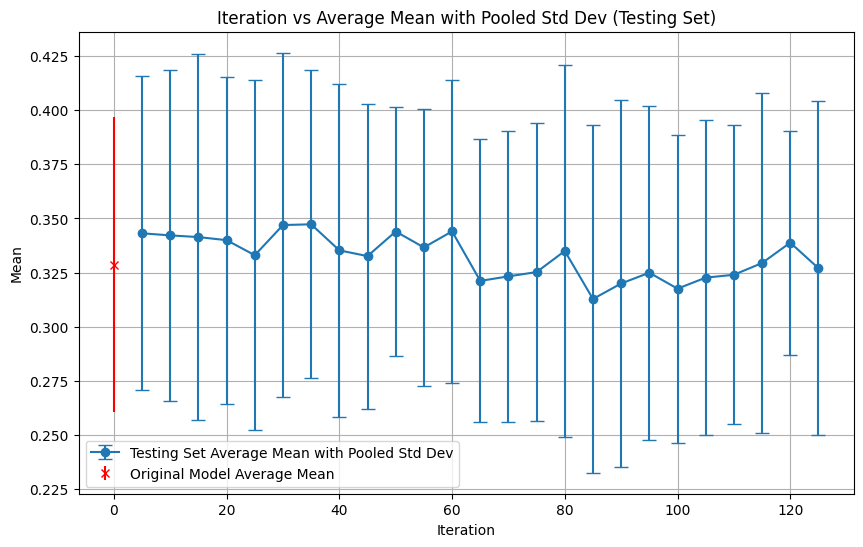

In [2]:
model_output_dir = '/work/b0990106x/trl/model_output/1019-1246'
log_path = f'{model_output_dir}/log_training.log'

import re
import matplotlib.pyplot as plt
import ast
import numpy as np

# Function to parse the log file for both EVAL and Original model metrics
def parse_log_file(log_path):
    eval_pattern = re.compile(
        r"EVAL: Cosine_Sim metrics (\w+) Set for iteration (\d+): (.+)"
    )
    original_model_pattern = re.compile(
        r"Original model metrics on testing set: (.+)"
    )
    
    data = {"EVAL": {}, "Original": []}

    # Read the log file line by line
    with open(log_path, 'r') as log_file:
        for line in log_file:
            eval_match = eval_pattern.search(line)
            original_match = original_model_pattern.search(line)

            # If it's an EVAL line
            if eval_match:
                data_set = eval_match.group(1)  # Captures the type of data set (Training, Testing, etc.)
                iteration = int(eval_match.group(2)) + 1  # Adding 1 to iteration as requested
                metrics_list = eval_match.group(3).strip()

                # Convert the metrics_list string to a Python object (list of dicts)
                metrics_list = ast.literal_eval(metrics_list)

                # Store means and std_devs for this iteration
                means = []
                std_devs = []
                counts = []

                for metrics in metrics_list:
                    mean = metrics['metrics']['mean']
                    std_dev = metrics['metrics']['std_dev']
                    count = len(metrics['metrics']['rewards'])  # Number of rewards is the sample size

                    means.append(mean)
                    std_devs.append(std_dev)
                    counts.append(count)

                # Store mean, std_dev, and count for each iteration under the specific dataset type
                if data_set not in data["EVAL"]:
                    data["EVAL"][data_set] = {}
                
                data["EVAL"][data_set][iteration] = {
                    "means": means,
                    "std_devs": std_devs,
                    "counts": counts
                }

            # If it's an Original Model Metrics line
            elif original_match:
                metrics_list = original_match.group(1).strip()

                # Convert the metrics_list string to a Python object (list of dicts)
                metrics_list = ast.literal_eval(metrics_list)

                for metrics in metrics_list:
                    mean = metrics['metrics']['mean']
                    std_dev = metrics['metrics']['std_dev']
                    data["Original"].append((mean, std_dev))

    return data

# Function to calculate the pooled standard deviation
def pooled_std_dev(std_devs, counts):
    # Pooled variance formula
    numerator = sum((counts[i] - 1) * (std_devs[i] ** 2) for i in range(len(std_devs)))
    denominator = sum(counts[i] - 1 for i in range(len(counts)))

    if denominator > 0:
        pooled_variance = numerator / denominator
        return np.sqrt(pooled_variance)
    else:
        return 0  # In case of single value or no variance

# Function to plot iteration vs the average mean and pooled std_dev
def plot_metrics(data, dataset_type='Testing'):
    plt.figure(figsize=(10, 6))

    # Plot EVAL data (average across all idx)
    if dataset_type not in data["EVAL"]:
        print(f"No data available for {dataset_type} set.")
        return

    iterations = sorted(data["EVAL"][dataset_type].keys())
    avg_means = []
    pooled_std_devs = []
    
    print(f"Total iterations: {len(iterations)}")
    print(f"Total Original Model data: {len(data['Original'])}")

    for iteration in iterations:
        means = data["EVAL"][dataset_type][iteration]["means"]
        std_devs = data["EVAL"][dataset_type][iteration]["std_devs"]
        counts = data["EVAL"][dataset_type][iteration]["counts"]
        
        # Calculate the average mean for the iteration
        avg_mean = sum(means) / len(means)
        avg_means.append(avg_mean)

        # Calculate the pooled standard deviation for the iteration
        pooled_std_dev_value = pooled_std_dev(std_devs, counts)
        pooled_std_devs.append(pooled_std_dev_value)

    # Plot the average means with pooled std_dev as error bars
    plt.errorbar(iterations, avg_means, yerr=pooled_std_devs, fmt='o-', capsize=5, label=f'{dataset_type} Set Average Mean with Pooled Std Dev')

    # Plot Original Model data (if available)
    if "Original" in data and len(data["Original"]) > 0:
        original_means = [item[0] for item in data["Original"]]
        original_std_devs = [item[1] for item in data["Original"]]
        avg_original_mean = np.mean(original_means)
        pooled_original_std_dev = pooled_std_dev(original_std_devs, [10] * len(original_std_devs))  # Assuming 10 samples per idx

        plt.errorbar([0], [avg_original_mean], yerr=[pooled_original_std_dev], fmt='x', color='r', label='Original Model Average Mean')

    plt.xlabel('Iteration')
    plt.ylabel('Mean')
    plt.title(f'Iteration vs Average Mean with Pooled Std Dev ({dataset_type} Set)')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage:
data = parse_log_file(log_path)
plot_metrics(data, dataset_type='Testing')  # Plot for the Testing set
